In [1]:
!pip install -q kaggle

In [2]:
! mkdir ~/.kaggle
! cp -f kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d emirhanai/planets-and-moons-dataset-ai-in-space

 97% 45.0M/46.4M [00:00<00:00, 53.0MB/s]
100% 46.4M/46.4M [00:00<00:00, 56.7MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/planets-and-moons-dataset-ai-in-space.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [16]:
train_datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.05,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.05,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False, 
            rescale=1 / 255.0, #os bits da imagem agr tem 0 e 1 
            fill_mode="nearest",
            validation_split=0.15)  # randomly flip images
train_generator = train_datagen.flow_from_directory("/content/Planets_Moons_Data/Planets and Moons",target_size=(170, 170),
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    interpolation="lanczos",
                                                    subset="training")
valid_generator = train_datagen.flow_from_directory("/content/Planets_Moons_Data/Planets and Moons",target_size=(170, 170),
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    interpolation="lanczos",
                                                    subset="validation")

Found 1396 images belonging to 11 classes.
Found 242 images belonging to 11 classes.


In [18]:
from keras.applications import VGG19
from keras.optimizers import SGD
from keras import Sequential
from keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout

# https://www.kaggle.com/code/drvaibhavkumar/cifar10-classification-using-vgg-transfer-learning
base_model = VGG19(include_top=False, weights="imagenet", input_shape=(170, 170, 3), classes=11)

model= Sequential()
model.add(base_model) #Adds the base model (in this case vgg19 to model)
model.add(Flatten()) #Since the output before the flatten layer is a matrix we have to use this function to get a vector of the form nX1 to feed it into the fully connected layers

#Adding the Dense layers along with activation and batch normalization
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.3)) #Adding a dropout layer that will randomly drop 30% of the weights
model.add(Dense(128,activation=('relu')))
model.add(Dropout(.2))

#aqui que vê quantas classificações
model.add(Dense(11, activation=('softmax'))) #This is the classification layer

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0         
                                                                 
 dense_10 (Dense)            (None, 1024)              13108224  
                                                                 
 dense_11 (Dense)            (None, 512)               524800    
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)              

In [20]:
#Defining the parameters
learn_rate=.001

# https://stackoverflow.com/questions/49922252/choosing-number-of-steps-per-epoch
batch_size=138
epochs=4

# https://keras.io/api/optimizers/sgd/
sgd = SGD(learning_rate=learn_rate, momentum=.9, nesterov=True)

# Optimizer: https://keras.io/api/optimizers/sgd/
# Função de perda: sparse_categorical_crossentropy para >= 3 classes
model.compile(loss='categorical_crossentropy', optimizer=sgd ,metrics=['accuracy'])

In [21]:
history = model.fit(train_generator,
                        validation_data= valid_generator,
                        epochs=10,
                        verbose=1,
                        batch_size=86)

Epoch 1/10
22/22 [==============================] - 2092s 95s/step - loss: 2.1421 - accuracy: 0.2722 - val_loss: 1.4286 - val_accuracy: 0.5868
Epoch 2/10
22/22 [==============================] - 2202s 100s/step - loss: 0.9825 - accuracy: 0.6698 - val_loss: 0.1687 - val_accuracy: 0.9793
Epoch 3/10
22/22 [==============================] - 2114s 96s/step - loss: 0.4269 - accuracy: 0.8746 - val_loss: 0.1019 - val_accuracy: 0.9917
Epoch 4/10
22/22 [==============================] - 2112s 96s/step - loss: 0.1357 - accuracy: 0.9556 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 5/10
22/22 [==============================] - 2141s 97s/step - loss: 0.2070 - accuracy: 0.9456 - val_loss: 0.0311 - val_accuracy: 0.9959
Epoch 6/10
22/22 [==============================] - 2223s 101s/step - loss: 0.0878 - accuracy: 0.9742 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 7/10
22/22 [==============================] - 2067s 94s/step - loss: 0.0145 - accuracy: 0.9950 - val_loss: 3.5854e-04 - val_accuracy: 

In [22]:
from google.colab import drive
drive.mount('/content/drive')
model.save("/content/drive/MyDrive/models/modelPlanets-MoonsData.h5")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


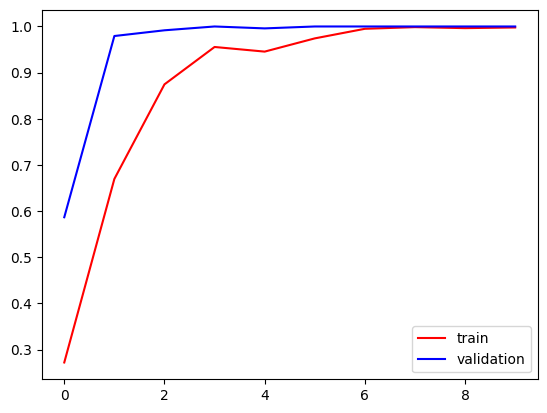

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

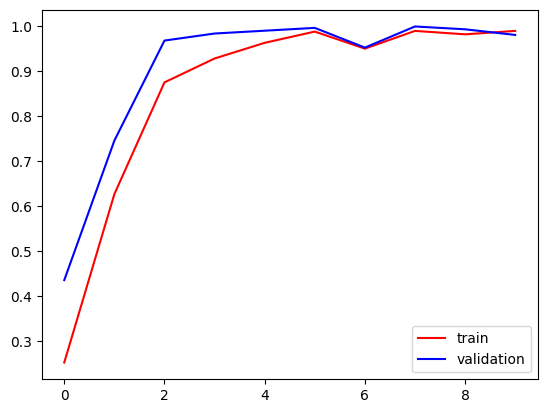

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()